# Capstone Project I

Data source: https://www.cde.ca.gov/ds/ad/downloadabledata.asp#SRD

**Question to answer**: What is the percentage of students from a California high school that will meet UC/CSU entrance requirements by the time they graduate? 

**Expected data source:**
The data that will be used is sourced from California's Department of Education (CDE) website. Data on public school type (i.e., charter/magnet/year-round/virtual/etc.), and the city the public school is in will be used to predict the percentage of students in a California high school meeting UC/CSU requirements. Because these information is uploaded separately on the CDE website, the most recent year that is reported for all data categories is the 2016-2017 school year.

**Technique expected to be used in your analysis:**
Linear regression would be the most appropriate technique to use in this machine learning problem rather than classification techniques such as logistic regression, KNN, decision trees, and support vector machines.

### 1) Import Libraries

In [1]:
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
import category_encoders as ce

### 2) Organizing Data

#### 2.1) Public Schools Data

In [2]:
public_schools = pd.read_csv("data/pubschls.txt", sep="\t", header=None, engine='python')
public_schools_df = public_schools.rename(columns=public_schools.iloc[0]).drop(public_schools.index[0])
public_high_schools = public_schools_df.query("EILName == 'High School' and StatusType == 'Active'")
public_high_schools_index = public_high_schools.set_index('CDSCode')

print(len(public_high_schools_index))
public_high_schools_index.head()

2212


,NCESDist,NCESSchool,StatusType,County,District,School,Street,StreetAbr,City,Zip,...,Virtual,Magnet,YearRoundYN,FederalDFCDistrictID,Latitude,Longitude,AdmFName,AdmLName,AdmEmail,LastUpDate
CDSCode,,,,,,,,,,,,,,,,,,,,,
01100170130401,0691051,09264,Active,Alameda,Alameda County Office of Education,Alameda County Juvenile Hall/Court,2500 Fairmont Avenue,2500 Fairmont Ave.,San Leandro,94578-1005,...,N,N,N,No Data,37.712878,-122.11173,Sean,Moffatt,smoffatt@acoe.org,11/04/2021
01100170130419,0691051,06830,Active,Alameda,Alameda County Office of Education,Alameda County Community,313 West Winton Avenue,313 West Winton Ave.,Hayward,94544-1136,...,C,N,N,No Data,37.658212,-122.09713,Carolyn,Hobbs,chobbs@acoe.org,11/04/2021
01100170130625,0691051,08674,Active,Alameda,Alameda County Office of Education,Alternatives in Action,6221 East 17th Street,6221 East 17th St.,Oakland,94621-4107,...,N,N,N,0601635,37.764464,-122.19540,Phung,Lai,plai@alternativesinaction.org,08/24/2021
01100170136226,0691051,14090,Active,Alameda,Alameda County Office of Education,Opportunity Academy,313 West Winton Avenue,313 West Winton Ave.,Hayward,94544-1136,...,C,N,N,No Data,37.658510,-122.09834,Tracey,Burns,tburns@acoe.org,08/10/2022
01611190106401,0601770,10547,Active,Alameda,Alameda Unified,Alameda Science and Technology Institute,555 Ralph Appezzato Memorial Parkway,555 Ralph Appezzato Memorial Pkwy.,Alameda,94501-2109,...,N,Y,Y,No Data,37.780753,-122.27930,Tracy,Corbally,tcorbally@alamedaunified.org,01/21/2022


#### 2.2) Number of students who are UC/CSU ready

In [3]:
grad_UC_CSU = pd.read_csv('data/filesgradaf.asp.txt', sep="\t", header=None, engine='python')
grad_UC_CSU_df = grad_UC_CSU.rename(columns=grad_UC_CSU.iloc[0]).drop(grad_UC_CSU.index[0])
grad_UC_CSU_df_rename = grad_UC_CSU_df.rename(columns = {"CDS_CODE": "CDSCode"})
grad_UC_CSU_index = grad_UC_CSU_df_rename.set_index('CDSCode')

print(len(grad_UC_CSU_index))
grad_UC_CSU_index.head()

2535


,COUNTY,DISTRICT,SCHOOL,HISPANIC,AM_IND,ASIAN,PAC_ISLD,FILIPINO,AFRICAN_AM,WHITE,TWO_MORE_RACES,NOT_REPORTED,TOTAL,YEAR
CDSCode,,,,,,,,,,,,,,
01100170112607,Alameda,Alameda County Office of Education,Envision Academy for Arts & Technology,37,1,2,0,0,24,5,0,0,69,1617
01100170130401,Alameda,Alameda County Office of Education,Alameda County Juvenile Hall/Court,0,0,0,0,0,0,0,0,0,0,1617
01100170130419,Alameda,Alameda County Office of Education,Alameda County Community,0,0,0,0,0,0,0,0,0,0,1617
01316170131763,Alameda,California School for the Deaf-Fremont (State ...,California School for the Deaf-Fremont,0,0,0,0,0,0,0,0,0,0,1617
01611190000001,Alameda,Alameda Unified,"Nonpublic, Nonsectarian Schools",0,0,0,0,0,0,0,0,0,0,1617


#### 2.3) Gather information on total number of students enrolled in grade 12 for each high school

In [4]:
grade_enroll = pd.read_csv('data/census_enrollment.txt', sep="\t", header=None, engine='python')
grade_enroll_df = grade_enroll.rename(columns=grade_enroll.iloc[0]).drop(grade_enroll.index[0])
grade_enroll_rename = grade_enroll_df.rename(columns = {"CDS_CODE": "CDSCode"})
grade_enroll_index = grade_enroll_rename.set_index('CDSCode')
grade_enroll_index['GR_12'] = grade_enroll_index['GR_12'].astype(float)

# Extract the features of interest.
grade_enroll_feature = grade_enroll_index[['GR_12']]
grade_12_enroll_features = grade_enroll_feature.query('GR_12 > 0')
grade_12_enroll_features_sum = grade_12_enroll_features.groupby(grade_12_enroll_features.index).sum()

print(len(grade_12_enroll_features_sum))
grade_12_enroll_features_sum.head()

2760


,GR_12
CDSCode,
01100170112607,81.0
01100170130401,39.0
01100170130419,133.0
01316090131755,9.0
01316170131763,86.0


### 3) Merge dataframes together

#### 3.1) Merge public_high_schools_index with grad_UC_CSU_index

In [5]:
public_school_UC_CSU = pd.merge(left = public_high_schools_index, right = grad_UC_CSU_index, left_on = 'CDSCode', right_on = 'CDSCode', how = 'inner')

print(len(public_school_UC_CSU))
public_school_UC_CSU.head()

1873


,NCESDist,NCESSchool,StatusType,County,District,School,Street,StreetAbr,City,Zip,...,AM_IND,ASIAN,PAC_ISLD,FILIPINO,AFRICAN_AM,WHITE,TWO_MORE_RACES,NOT_REPORTED,TOTAL,YEAR
CDSCode,,,,,,,,,,,,,,,,,,,,,
01100170130401,0691051,09264,Active,Alameda,Alameda County Office of Education,Alameda County Juvenile Hall/Court,2500 Fairmont Avenue,2500 Fairmont Ave.,San Leandro,94578-1005,...,0,0,0,0,0,0,0,0,0,1617
01100170130419,0691051,06830,Active,Alameda,Alameda County Office of Education,Alameda County Community,313 West Winton Avenue,313 West Winton Ave.,Hayward,94544-1136,...,0,0,0,0,0,0,0,0,0,1617
01611190106401,0601770,10547,Active,Alameda,Alameda Unified,Alameda Science and Technology Institute,555 Ralph Appezzato Memorial Parkway,555 Ralph Appezzato Memorial Pkwy.,Alameda,94501-2109,...,0,24,1,5,1,2,1,0,42,1617
01611190130229,0601770,00041,Active,Alameda,Alameda Unified,Alameda High,2200 Central Avenue,2200 Central Ave.,Alameda,94501-4406,...,1,135,0,7,13,83,6,0,262,1617
01611190134304,0601770,00048,Active,Alameda,Alameda Unified,Island High (Continuation),500 Pacific Avenue,500 Pacific Ave.,Alameda,94501-2125,...,0,0,0,0,0,0,0,0,0,1617


#### 3.2) Merge public_school_UC_CSU with grade_12_enroll_features

In [6]:
public_school_UC_CSU_grd_12 = pd.merge(left = public_school_UC_CSU, right = grade_12_enroll_features_sum, left_on = 'CDSCode', right_on = 'CDSCode', how = 'inner')

print(len(public_school_UC_CSU_grd_12))
public_school_UC_CSU_grd_12.head()

1866


,NCESDist,NCESSchool,StatusType,County,District,School,Street,StreetAbr,City,Zip,...,ASIAN,PAC_ISLD,FILIPINO,AFRICAN_AM,WHITE,TWO_MORE_RACES,NOT_REPORTED,TOTAL,YEAR,GR_12
CDSCode,,,,,,,,,,,,,,,,,,,,,
01100170130401,0691051,09264,Active,Alameda,Alameda County Office of Education,Alameda County Juvenile Hall/Court,2500 Fairmont Avenue,2500 Fairmont Ave.,San Leandro,94578-1005,...,0,0,0,0,0,0,0,0,1617,39.0
01100170130419,0691051,06830,Active,Alameda,Alameda County Office of Education,Alameda County Community,313 West Winton Avenue,313 West Winton Ave.,Hayward,94544-1136,...,0,0,0,0,0,0,0,0,1617,133.0
01611190106401,0601770,10547,Active,Alameda,Alameda Unified,Alameda Science and Technology Institute,555 Ralph Appezzato Memorial Parkway,555 Ralph Appezzato Memorial Pkwy.,Alameda,94501-2109,...,24,1,5,1,2,1,0,42,1617,44.0
01611190130229,0601770,00041,Active,Alameda,Alameda Unified,Alameda High,2200 Central Avenue,2200 Central Ave.,Alameda,94501-4406,...,135,0,7,13,83,6,0,262,1617,419.0
01611190134304,0601770,00048,Active,Alameda,Alameda Unified,Island High (Continuation),500 Pacific Avenue,500 Pacific Ave.,Alameda,94501-2125,...,0,0,0,0,0,0,0,0,1617,99.0


In [7]:
public_school_UC_CSU_grd_12.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1866 entries, 01100170130401 to 58727695838305
Data columns (total 61 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NCESDist              1866 non-null   object 
 1   NCESSchool            1866 non-null   object 
 2   StatusType            1866 non-null   object 
 3   County                1866 non-null   object 
 4   District              1866 non-null   object 
 5   School                1866 non-null   object 
 6   Street                1866 non-null   object 
 7   StreetAbr             1866 non-null   object 
 8   City                  1866 non-null   object 
 9   Zip                   1866 non-null   object 
 10  State                 1866 non-null   object 
 11  MailStreet            1866 non-null   object 
 12  MailStrAbr            1866 non-null   object 
 13  MailCity              1866 non-null   object 
 14  MailZip               1866 non-null   object 
 15  Mai

### 4) Data cleaning

In [8]:
# Extract the features of interest.
df = public_school_UC_CSU_grd_12[['City', 'Charter', 'Virtual', 'Magnet', 'YearRoundYN', 'TOTAL', 'GR_12']]

df['TOTAL'] = df['TOTAL'].astype(float)
df

,City,Charter,Virtual,Magnet,YearRoundYN,TOTAL,GR_12
CDSCode,,,,,,,
01100170130401,San Leandro,N,N,N,N,0.0,39.0
01100170130419,Hayward,N,C,N,N,0.0,133.0
01611190106401,Alameda,N,N,Y,Y,42.0,44.0
01611190130229,Alameda,N,N,N,Y,262.0,419.0
01611190134304,Alameda,N,N,N,Y,0.0,99.0
...,...,...,...,...,...,...,...
58727365830013,Olivehurst,N,N,N,N,63.0,230.0
58727365830096,Olivehurst,N,N,N,N,0.0,88.0
58727365830138,Marysville,Y,N,N,N,32.0,46.0


In [9]:
# Calculate the percentage of students in grade 12 who are UC/CSU-ready
df['%_UC_CSU_ready'] = df['TOTAL']/df['GR_12']
df

,City,Charter,Virtual,Magnet,YearRoundYN,TOTAL,GR_12,%_UC_CSU_ready
CDSCode,,,,,,,,
01100170130401,San Leandro,N,N,N,N,0.0,39.0,0.000000
01100170130419,Hayward,N,C,N,N,0.0,133.0,0.000000
01611190106401,Alameda,N,N,Y,Y,42.0,44.0,0.954545
01611190130229,Alameda,N,N,N,Y,262.0,419.0,0.625298
01611190134304,Alameda,N,N,N,Y,0.0,99.0,0.000000
...,...,...,...,...,...,...,...,...
58727365830013,Olivehurst,N,N,N,N,63.0,230.0,0.273913
58727365830096,Olivehurst,N,N,N,N,0.0,88.0,0.000000
58727365830138,Marysville,Y,N,N,N,32.0,46.0,0.695652


In [10]:
# Binary encode the "Charter", "Magnet", and "YearRoundYN" columns
df_copy = df.copy()
df_copy['Charter'] = df_copy['Charter'].map({'Y': 1, 'N': 0})
df_copy['Magnet'] = df_copy['Magnet'].map({'Y': 1, 'N': 0})
df_copy['YearRoundYN'] = df_copy['YearRoundYN'].map({'Y': 1, 'N': 0})
df_copy

,City,Charter,Virtual,Magnet,YearRoundYN,TOTAL,GR_12,%_UC_CSU_ready
CDSCode,,,,,,,,
01100170130401,San Leandro,0,N,0,0,0.0,39.0,0.000000
01100170130419,Hayward,0,C,0,0,0.0,133.0,0.000000
01611190106401,Alameda,0,N,1,1,42.0,44.0,0.954545
01611190130229,Alameda,0,N,0,1,262.0,419.0,0.625298
01611190134304,Alameda,0,N,0,1,0.0,99.0,0.000000
...,...,...,...,...,...,...,...,...
58727365830013,Olivehurst,0,N,0,0,63.0,230.0,0.273913
58727365830096,Olivehurst,0,N,0,0,0.0,88.0,0.000000
58727365830138,Marysville,1,N,0,0,32.0,46.0,0.695652


#### Explanation of features
**City**: Identifies the City where the high school is located in

**Charter**: 0 = school is not a charter school; 1 = school is charter school

**Virtual**: 

F = Exclusively Virtual – The school has no physical building where students meet with each other or with teachers, all instruction is virtual.

V = Primarily Virtual – The school focuses on a systematic program of virtual instruction but includes some physical meetings among students or with teachers.

C = Primarily Classroom – The school offers virtual courses but virtual instruction is not the primary means of instruction.

N = Not Virtual – The school does not offer any virtual instruction.


**Magnet**: 0 = school is not a magnet school; 1 = school is a magnet school

**YearRoundYN**: 0 = school is not a year-round school; 1 = school is a year-round school

**%_UC_CSU_ready**: = percent of students in high school who are UC/CSU-ready

In [12]:
# Extract features of interest
df_features = df_copy[['City', 'Charter', 'Virtual', 'Magnet', 'YearRoundYN', '%_UC_CSU_ready']]
df_features

,City,Charter,Virtual,Magnet,YearRoundYN,%_UC_CSU_ready
CDSCode,,,,,,
01100170130401,San Leandro,0,N,0,0,0.000000
01100170130419,Hayward,0,C,0,0,0.000000
01611190106401,Alameda,0,N,1,1,0.954545
01611190130229,Alameda,0,N,0,1,0.625298
01611190134304,Alameda,0,N,0,1,0.000000
...,...,...,...,...,...,...
58727365830013,Olivehurst,0,N,0,0,0.273913
58727365830096,Olivehurst,0,N,0,0,0.000000
58727365830138,Marysville,1,N,0,0,0.695652


In [14]:
# leave-one-out-encoding for "Virtual" and "City" columns
encoder = ce.LeaveOneOutEncoder(return_df = True)
df_loo = encoder.fit_transform(df_features, df_features['%_UC_CSU_ready'])
df_loo

,City,Charter,Virtual,Magnet,YearRoundYN,%_UC_CSU_ready
CDSCode,,,,,,
01100170130401,0.166949,0,0.317916,0,0,0.000000
01100170130419,0.246413,0,0.333681,0,0,0.000000
01611190106401,0.312649,0,0.317128,1,1,0.954545
01611190130229,0.477273,0,0.317400,0,1,0.625298
01611190134304,0.789922,0,0.317916,0,1,0.000000
...,...,...,...,...,...,...
58727365830013,0.000000,0,0.317690,0,0,0.273913
58727365830096,0.273913,0,0.317916,0,0,0.000000
58727365830138,0.101449,1,0.317342,0,0,0.695652


### 5) Visualize Data

#### 5.1) Number of 12th grade classrooms that have no virtual options (N), are primarily structured in person (C), are primarily virtual (V), and exclusively virtual (F)

<AxesSubplot:xlabel='Virtual', ylabel='Count'>

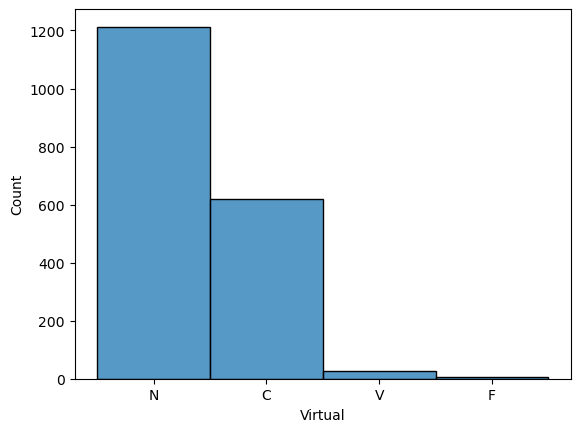

In [16]:
sns.histplot(data=df_features, x="Virtual")

#### 5.2) Number of California high schools that are Charter schools

<AxesSubplot:xlabel='Charter', ylabel='Count'>

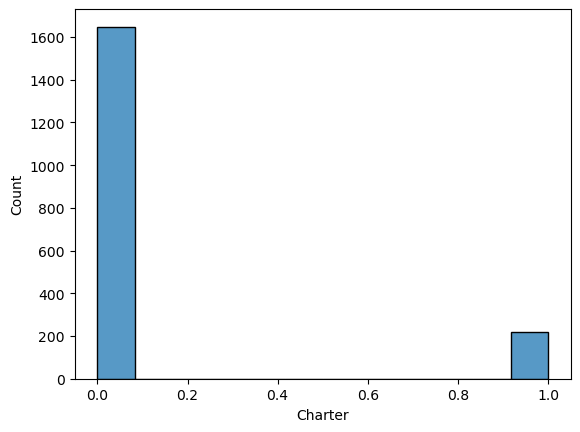

In [18]:
sns.histplot(data=df_features, x="Charter")

#### 5.3) Number of California high schools that are Magnet schools

<AxesSubplot:xlabel='Magnet', ylabel='Count'>

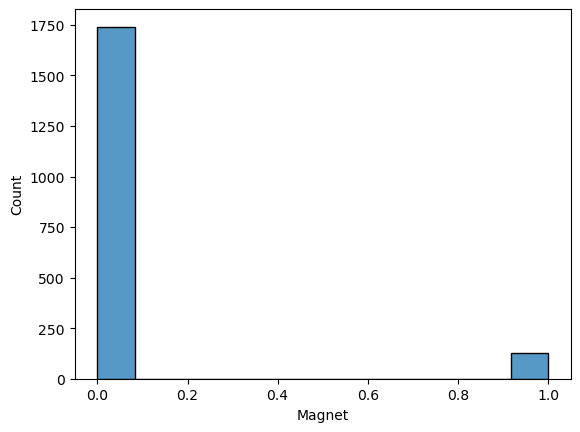

In [19]:
sns.histplot(data=df_features, x="Magnet")

#### 5.4) Number of California high schools that are Year-Round schools

<AxesSubplot:xlabel='YearRoundYN', ylabel='Count'>

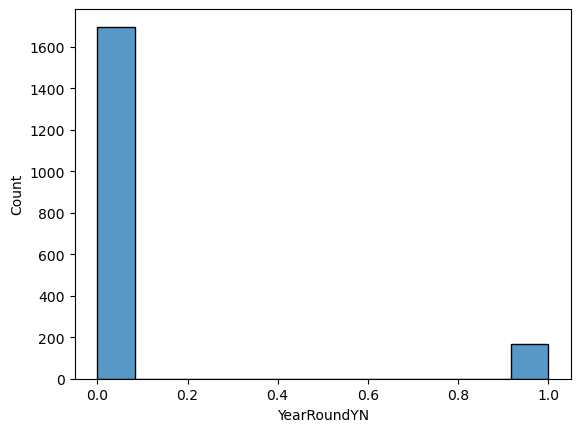

In [20]:
sns.histplot(data=df_features, x="YearRoundYN")

### 6) Split the data

In [21]:
X = df_loo.drop(['%_UC_CSU_ready'], axis=1)
y = df_loo['%_UC_CSU_ready']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### 7) Model

#### 7.1) Loading the linear regression model and fitting the model to dataset

In [22]:
# Loading the linear regression model
lin_reg_model = LinearRegression()

In [23]:
# fit the model to dataset
lin_reg_model.fit(X_train, y_train)

LinearRegression()

#### 7.2) Calculating training and test mean squared errors

In [24]:
y_pred_train = lin_reg_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_mse

0.07185690340104932

In [26]:
y_pred_test = lin_reg_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mse

0.07393284625249999

#### 7.3) Calculating the accuracy of the model

In [28]:
lin_reg_accuracy = lin_reg_model.score(X_train,y_train)
lin_reg_accuracy

0.11976029447438696

### Summary:
In part I of the capstone project, I attempted to predict the percentage of students from each California high school who are UC/CSU-ready. The features I looked into were: public school type (i.e., charter/magnet/year-round/virtual/etc.), and the city the public school is in. Because all this data were spread out into different datasets, the first part of this assignment (section 2) was devoted to cleaning the data from the  California's Department of Education (CDE) website and merging the different datasets into one dataframe. I fitted the linear regression model to this dataframe.

### Conclusion:
The training and test mse's are relatively similar indicating that the model's predictablility among the training set is very similar to that of the test set. However, the model's accuracy is relatively low. Perhaps more features should be included and/or an ensemble model should be used instead. I will learn more about ensemble models in the next module.